In [1]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from tensorflow import keras
from collections import Counter
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.3.0'

### Get Dataset

In [3]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    184      0 --:--:-- --:--:-- --:--:--   184
100 8863k  100 8863k    0     0  5850k      0  0:00:01  0:00:01 --:--:-- 28.0M
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16

img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'2', '3', '4', 'p', '6', '8', 'y', 'b', 'w', 'm', 'f', 'c', 'd', 'x', '5', 'n', '7', 'g', 'e'}


### Preprocessing

In [5]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary = list(characters), num_oov_indices = 0, mask_token = None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True
)


def split_data(images, labels, train_size = 0.9, shuffle = True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels = 1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm = [1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding = "UTF-8"))
    return {"image": img, "label": label}

### Create Dataset objects

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls = tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls = tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
)

### Visualize Dataset

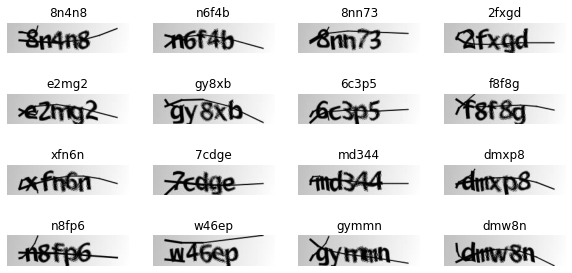

In [7]:
_, ax = plt.subplots(4, 4, figsize = (10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

### Model

In [8]:
class CTCLayer(layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")

        input_length = input_length * tf.ones(shape = (batch_len, 1), dtype = "int64")
        label_length = label_length * tf.ones(shape = (batch_len, 1), dtype = "int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    input_img = layers.Input(
        shape = (img_width, img_height, 1), name = "image", dtype = "float32"
    )
    labels = layers.Input(name = "label", shape = (None,), dtype = "float32")

    x = layers.Conv2D(
        32,
        (3, 3),
        activation = "relu",
        kernel_initializer = "he_normal",
        padding = "same",
        name = "Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name = "pool1")(x)

    x = layers.Conv2D(
        64,
        (3, 3),
        activation = "relu",
        kernel_initializer = "he_normal",
        padding = "same",
        name = "Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name = "pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape = new_shape, name = "reshape")(x)
    x = layers.Dense(64, activation = "relu", name = "dense1")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences = True, dropout = 0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences = True, dropout = 0.25))(x)

    x = layers.Dense(len(characters) + 1, activation = "softmax", name = "dense2")(x)

    output = CTCLayer(name = "ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs = [input_img, labels], outputs = output, name = "ocr_model_v1"
    )

    opt = keras.optimizers.Adam()

    model.compile(optimizer = opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

### Train

In [9]:
epochs = 100
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = early_stopping_patience, restore_best_weights = True
)

history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = epochs,
    callbacks = [early_stopping],
)

Epoch 1/100
59/59 [==============================] - 3s 56ms/step - loss: 22.6999 - val_loss: 16.3892
Epoch 2/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3325 - val_loss: 16.3914
Epoch 3/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3287 - val_loss: 16.3884
Epoch 4/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3237 - val_loss: 16.3920
Epoch 5/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3138 - val_loss: 16.3733
Epoch 6/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3073 - val_loss: 16.3566
Epoch 7/100
59/59 [==============================] - 2s 32ms/step - loss: 16.2886 - val_loss: 16.3120
Epoch 8/100
59/59 [==============================] - 2s 32ms/step - loss: 16.2641 - val_loss: 16.2538
Epoch 9/100
59/59 [==============================] - 2s 32ms/step - loss: 16.2348 - val_loss: 16.2174
Epoch 10/100
59/59 [==============================] - 2s 32ms/step - loss: 16.1769